[Run on Colab](https://colab.research.google.com/drive/1VwWV3CuREOYR60yrrsrEGy_j8jsKBgKm#scrollTo=Sb66hWQ5-ulU)

# Model validation with external data
In this notebook I will try to get the performance of the model on an external dataset I have obtained from a public repository, like ChEMBL, PubChem, Therapeutics Data Commons or MoleculeNet.

I need to find a dataset for which experimental data exactly as the one used to train my model of interest is available.

# About the Dataset

The dataset contains 4510 data which is a subset of Aqueous Solubility from MLSMR Stock Solutions [PubChem AID 1996](https://pubchem.ncbi.nlm.nih.gov/bioassay/1996).

# Import necessary libraries
In this codeblock I will import the necessary packages and specify the paths to relevant folders

In [5]:


## Mount google drive
from google.colab import drive
drive.mount("/content/drive")
import sys

_ = sys.path.append("/usr/local/lib/python3.7/site-packages")


sys.path.append("/content/drive/MyDrive/Ersilia_ModelValidation")


!pip install rdkit



import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from src.src import standardise_smiles
from src.src import get_inchikey
from sklearn.metrics import roc_curve, auc, roc_auc_score, balanced_accuracy_score, confusion_matrix



# specify your output folder

output_folder = "/content/drive/MyDrive/Ersilia_ModelValidation/Data/Output"  # @param {type:"string"}

# specify the input folder path

input_folder = "/content/drive/MyDrive/Ersilia_ModelValidation/Data/Input"  # @param {type:"string"}
plot_folder = "/content/drive/MyDrive/Ersilia_ModelValidation/Plots"  # @param {type:"string"}



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
plot_folder = "/content/drive/MyDrive/Ersilia_ModelValidation/Plots"  # @param {type:"string"}

# In this codeblock I will load the external dataset as a pandas dataframe

In [6]:
# Read the external data into pandas dataframe

test_data = pd.read_csv(os.path.join(input_folder, 'external_data.csv'))
# Map classes to solubility outcomes
test_data['Solubility'] = test_data['outcomes'].map({1: 'low_solubility', 0: 'high_solubility'})

# check the first five rows with its header
test_data.head()

,ID,Value,SMILES,outcomes,Solubility
0,>,46.0,COC1=CC=CC(=C1)CNC(=O)CCC(=O)N2CCOCC2,0,high_solubility
1,>,50.6,CCCCCC(=O)NC1=CC(=CC=C1)S(=O)(=O)NC2=NCCC2,0,high_solubility
2,>,46.6,C1=CC(=C(N=C1)NC(=O)CCC(=O)C2=CC=C(S2)Cl)O,0,high_solubility
3,>,47.0,COC1=CC=CC=C1C(=O)NCCC(=O)NCC2=CC=NC=C2,0,high_solubility
4,>,46.3,CN(C1CCS(=O)(=O)C1)C(=O)COC2=CC=CC(=C2)C#N,0,high_solubility


#  Exploratory Data Analysis


 Data distribution: How many molecules do I have in each class? How many low solubles and how many high solubles molecules?

In [8]:
#Count the number of molecules in each class
class_count= test_data['Solubility'].value_counts()
class_count

high_solubility    3177
low_solubility     1333
Name: Solubility, dtype: int64

### Let's visualise to understand the data

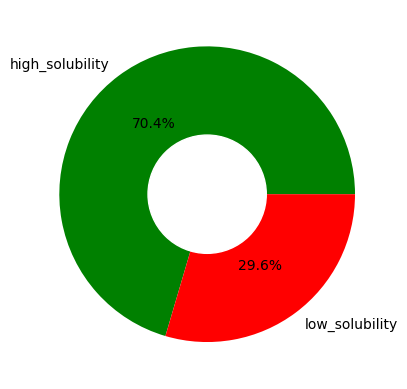

In [13]:
# use piechart to visualise the univariate categorical variable
#create a pieplot
plt.pie(class_count.values, labels=class_count.index, colors= ['green', 'red'],autopct='%1.1f%%')

my_circle= plt.Circle((0,0), 0.4, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
# Save the plot
plt.savefig(os.path.join(plot_folder, 'Model_external_data_validation','test_data_class_count.png'));

# Data Preprocessing
In this codeblocks I will process the external dataset so that I have a dataframe with three columns: standard smiles / InchiKey / experimental_value

In [14]:
# drop the id column
test_data= test_data.drop(columns= 'ID')


In [15]:
# check that the data contains valid smiles
smiles_list = test_data['SMILES'].tolist()

# List to store valid smiles and invalid smiles
valid_smiles = []
invalid_smiles = []

# Iterate over each smiles string
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        valid_smiles.append(smiles)
    else:
        invalid_smiles.append(smiles)

# Print the number of valid and invalid SMILES
print(f'Number of valid SMILES: {len(valid_smiles)}')
print(f'Number of invalid SMILES: {len(invalid_smiles)}')



Number of valid SMILES: 4510
Number of invalid SMILES: 0


In [16]:
# check for missing values
test_data.isnull().sum()

Value         0
SMILES        0
outcomes      0
Solubility    0
dtype: int64

In [17]:
test_data.duplicated().sum()

0

In [18]:
# create standardized_smiles column: Convert molecules to standard smiles by applying the standardise_smile function on the 'SMILE' column
test_data['standardized_smiles'] = test_data['SMILES'].apply(standardise_smiles)

In [19]:
# In this codeblock I will get the Inchikey representation of the molecules using the RDKIT package
# Apply the function to the "standardise_smile" column

test_data["inchi_key"] = test_data["SMILES"].apply(get_inchikey)

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Charges were rearranged

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefined stereo

[08:09:39] WARNING: Omitted undefin

In [20]:
# check the columns in the data
test_data.columns

Index(['Value', 'SMILES', 'outcomes', 'Solubility', 'standardized_smiles',
       'inchi_key'],
      dtype='object')

In [21]:
relevant_columns= ['standardized_smiles', 'inchi_key', 'outcomes']
test_data= test_data[relevant_columns]
new_columns= test_data.columns
print(f'The columns in the test_data are: {new_columns}')

The columns in the test_data are: Index(['standardized_smiles', 'inchi_key', 'outcomes'], dtype='object')


#  In this codeblock I will make sure there are no repeated molecules between the train set used in the model and the external dataset I curated
 Repeated molecules must be eliminated to avoid bias

In [22]:


train_data = pd.read_csv(os.path.join(input_folder, 'eos74bo_validation', 'train_data.csv'))

molecule_count = len(test_data)
# Extract unique identifiers (InChI keys)
train_identifiers = set(train_data['inchi_key'])
test_identifiers = set(test_data['inchi_key'])

# Check for overlap
overlap = train_identifiers.intersection(test_identifiers)

if overlap:
    print("Overlap detected. Common molecules:")
    common_molecules = train_data[train_data['inchi_key'].isin(overlap)]
    print(common_molecules)

    # Remove common molecules from test dataset
    test_data = test_data[~test_data['inchi_key'].isin(overlap)]
    print("Removed common molecules from test dataset.")
else:
    print("No overlap detected. Test dataset is unique.")
unique_molecule_count = len(test_data)
molecule_removed_count= molecule_count - unique_molecule_count
print(f"The count of molecules in the test data before cleaning is: {molecule_count}")
print(f"The count of unique molecules in the cleaned test data is: {unique_molecule_count}")
print(f"The count of common molecules in train and test data that was removed {molecule_removed_count}")


Overlap detected. Common molecules:
                                    standardized_smiles  \
132   CCn1cc(C(=O)O)c(=O)c2cnc(N3CCN(C(=S)Nc4ccccc4)...   
874                CS(=O)(=O)c1ccc2nc(NC(=O)C3CC3)sc2c1   
1416               O=C(Nc1ccccc1O)c1ccc(NC(=O)C2CC2)cc1   

                        inchi_key  outcomes  
132   ARGUMDNARGOSPU-UHFFFAOYSA-N         0  
874   IXYYBELPQCLWCW-UHFFFAOYSA-N         0  
1416  NWGMMNNPEZGBQM-UHFFFAOYSA-N         1  
Removed common molecules from test dataset.
The count of molecules in the test data before cleaning is: 4510
The count of unique molecules in the cleaned test data is: 4507
The count of common molecules in train and test data that was removed 3


Let's confirm that the common molecules has been eliminated

In [23]:
# Extract the unique Inchi_keys from train_data and test_data
train_inchi_keys = set(train_data['inchi_key'])
test_inchi_keys = set(test_data['inchi_key'])

# Check for common Inchi_keys
common_inchi_keys = train_inchi_keys.intersection(test_inchi_keys)

if len(common_inchi_keys) == 0:
    print("No common Inchi_keys found between train_data and test_data.")
else:
    print("There are common Inchi_keys between train_data and test_data.")
    print("Common Inchi_keys:", common_inchi_keys)

No common Inchi_keys found between train_data and test_data.


#  In this codeblocks, I will load the predictions I obtained with the EMH model and check several ML performance metrics

In [26]:

external_validation_prediction = pd.read_csv(os.path.join(output_folder, 'external_predictions_result.csv'))

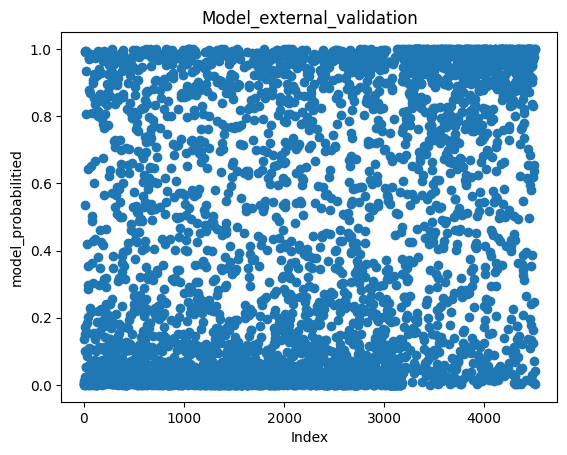

In [28]:
# Generate x values (indices)
x = range(len(external_validation_prediction))
plt.scatter(x, external_validation_prediction['predicted_probability'])
plt.xlabel('Index')
plt.ylabel('model_probabilitied')
plt.title('Model_external_validation')
# Save the plot
plt.savefig(os.path.join(plot_folder, 'Model_external_data_validation', 'scatter.png'))
plt.show()

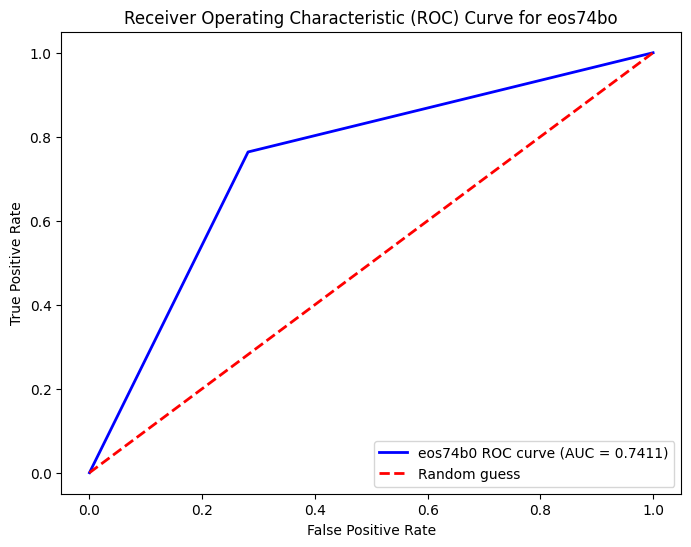

In [24]:
# evaluate the perfomance of the model on external dataset

fpr, tpr, thresholds = roc_curve(external_validation_prediction['outcomes'], external_validation_prediction['predicted_outcomes'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='eos74b0 ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for eos74bo')
plt.legend(loc='lower right')
# Save the plot
plt.savefig(os.path.join(plot_folder,'Model_external_data_validation', 'external_data_AUROC.png'))

plt.show()

In [25]:
# evaluate the model with the following metrics
auc_roc = roc_auc_score(external_validation_prediction['outcomes'], external_validation_prediction['predicted_outcomes'])
bacc = balanced_accuracy_score(external_validation_prediction['outcomes'], external_validation_prediction['predicted_outcomes'])
tn, fp, fn, tp = confusion_matrix(external_validation_prediction['outcomes'], external_validation_prediction['predicted_outcomes']).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


print(f'auc_roc score is {auc_roc:.4f}')
print(f'The balanced accuracy is {bacc:.4f}')
print(f'The sensitivity is {sensitivity:.4f} and the specificity is {specificity:.4f}')

auc_roc score is 0.7411
The balanced accuracy is 0.7411
The sensitivity is 0.7637 and the specificity is 0.7186



#Result Interpretation

An AUC-ROC (Area Under the Receiver Operating Characteristic Curve) score of 0.7411 means that the model's performance in terms of differentiating  between the positive(low solubility) and negative(high solubility) classes is relatively good because the closer the AUC-ROC score is to 1, the better the model's performance.

The model's balanced accuracy is 74.11% across both classes (i.e., active and inactive) as revealed in the balanced accuracy score. This is a useful metric when dealing with imbalanced dataset and this is the case with test dataset that I used.

Sensitivity score of 0.7637 means the model correctly identifies 76.37% of the positive cases (i.e. low soluble compounds) out of all actual positive case (all low soluble compounds in the data). The sensitivity is really important because we want to able to identify low soluble compounds correctly such that we do not mistakenly use poor soluble compounds to develop drugs which will be very costly since the focus is on minimizing Type 2 errors.

Specificity score of 0.7186 indicates that approximately 71.86% of the actual negative cases (high solubility molecules) are correctly identified as negative by the model.



# Conclusion

Results are based on a clean version of test data set by removing the four common samples in the train data set  and test data set.
